<a href="https://colab.research.google.com/github/Billl-11/CNN-Horse-vs-Human-Classifier/blob/main/CNN_Horse_and_Human_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network - Horse vs Human Classifier

This is an implementation of the Convolutional Neural Network model to classify horse or human images.


The datasets used in this project are sourced from the [Introduction to TensorFlow for Artificial Intelligence, Machine Learning, and Deep Learning.](https://www.coursera.org/learn/introduction-tensorflow/home/welcome) The course, created by DeepLearning.AI

## Datasets Preparation
There are two types of datasets, which is training datasets and validation datasets. Training datasets are the data that is used to tell the neural network model that 'this is what a horse looks like' and 'this is what a human looks like. Validation datasets are the data that is used to check the accuracy of the model from new images

In [3]:
# Download the training datasets
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Download the validation datasets
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2023-06-22 16:05:18--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  21.6MB/s    in 7.9s    

2023-06-22 16:05:26 (18.0 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2023-06-22 16:05:26--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187

In [4]:
import zipfile

# extract training dataset
zip_file = zipfile.ZipFile('./horse-or-human.zip','r')
zip_file.extractall('./horse-or-human')

# extract validation dataset
zip_file = zipfile.ZipFile('./validation-horse-or-human.zip','r')
zip_file.extractall('./validation-horse-or-human')

> The contents of the .zip are extracted to the base directory ./horse-or-human for training and ./validation-horse-or-human for validating, which in turn each contain horses and humans subdirectories

## Datasets Preprocessing
For this dataset, We do not have the label of each image as horses or humans. So, we will use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) API instead that will automatically label images according to the directory names and structure. For example, we will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageDataGenerator will label the images appropriately.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled to 0-1, 255 as divisor because each color pixel has values ranging from 0 to 255.
train_datagenerator = ImageDataGenerator(rescale=1/255)
validation_datagenerator = ImageDataGenerator(rescale=1/255)

train_generator = train_datagenerator.flow_from_directory(
    '/content/horse-or-human', # parent directory that contain sub directory for labels
    target_size = (300,300), # make all data sizes uniform
    batch_size = 128, # during each iteration of training, the model will process 128 images from the dataset
    class_mode = 'binary' # we use binary mode because this is a two-class classification problem
)

validation_generator = validation_datagenerator.flow_from_directory(
    '/content/validation-horse-or-human',
    target_size = (300,300),
    batch_size = 32,
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Build the model

### Neural Network Layers

For model architecture, we will use neural network with [Convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layer and [Pooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer.

- Convolution is applying filter to images to extract meaningful features from the input image
```
tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape(300,300,3))
```
Code above means a convolution layer with 64 filters, the filters will be 3x3 pixels in size, and the input image shape is 300x300 pixels in 3 color channels (RGB)

- Pooling layer  is used for downscaling and spatial dimension reduction
```
tf.keras.layers.MaxPooling2D(2,2)
```
The code above means picking the highest pixel values from 2x2 grid pixels, to capture the most important features by selecting the maximum response within each pooling region and reduces the spatial dimensions of the feature obtained from the previous convolutional layers.

- We use `activation='sigmoid'` in the last layer to make the output value of neural network a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [6]:
import tensorflow as tf

model = tf.keras.models.Sequential([

    # first convolution and pooling layer
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    # second convolution and pooling layer
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # flatten the pixel vector
    tf.keras.layers.Flatten(),

    # hidden layer with 512 neuron
    tf.keras.layers.Dense(128, activation='relu'),

    # hidden layer with 512 neuron
    tf.keras.layers.Dense(512, activation='relu'),

    # last/output layer, with 1 neuron and sigmoid function where the range is 0-1 because its the probability of 2 classes (either zero or one)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense (Dense)               (None, 128)               4

### Loss and optimizer
- To calculate the loss function, we use `loss = binary_crossentropy` because it's a binary classification problem
- For optimizer, we use [RMSprob optimization algorithm](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) with learning rate = 0.001

In [8]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy'])

### Model training
 We can observe on how fast the model trains and the accuracies we getting in the train and validation sets.

In [9]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 26s 1s/step - loss: 3.9373 - accuracy: 0.4912 - val_loss: 0.6888 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 10s 1s/step - loss: 0.7657 - accuracy: 0.5228 - val_loss: 0.6967 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 10s 1s/step - loss: 0.7353 - accuracy: 0.5996 - val_loss: 0.6763 - val_accuracy: 0.8594
Epoch 4/15
8/8 [==============================] - 10s 1s/step - loss: 0.7099 - accuracy: 0.6924 - val_loss: 0.7228 - val_accuracy: 0.5000
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.8758 - accuracy: 0.6874 - val_loss: 0.6373 - val_accuracy: 0.5469
Epoch 6/15
8/8 [==============================] - 10s 1s/step - loss: 0.7067 - accuracy: 0.6162 - val_loss: 0.6339 - val_accuracy: 0.5078
Epoch 7/15
8/8 [==============================] - 10s 1s/step - loss: 0.6229 - accuracy: 0.7731 - val_loss: 0.6916 - val_accuracy: 0.5234
Epoch 8/15
8/8 [===================

## Model Prediction

Saving download.jpg to download.jpg
1/1 [==============================] - 0s 249ms/step
[1.441986e-07]
download.jpg is a horse


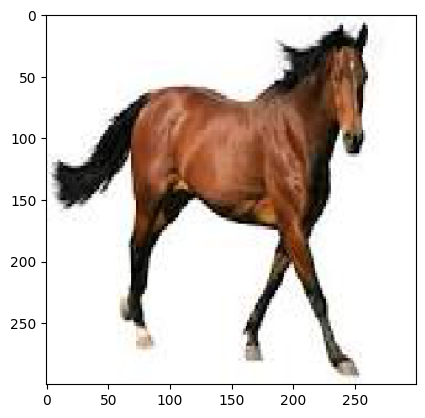

In [10]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  imgplot = plt.imshow(img)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


In [ ]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)

In [4]:
## Define datasets directories
# import os

# # training datasets
# train_horse = os.path.join('./horse-or-human/horses')
# train_human = os.path.join('./horse-or-human/humans')


# # validation datasets
# validation_horse = os.path.join('./validation-horse-or-human/horses')
# validation_human = os.path.join('./validation-horse-or-human/humans')

In [ ]:
# print(f'total training horse images: {len(os.listdir(train_horse))}')
# print(f'total training human images: {len(os.listdir(train_human))}')
# print(f'total validation horse images: {len(os.listdir(validation_horse))}')
# print(f'total validation human images: {len(os.listdir(validation_human))}')